# Case 1: Group Life Insurance

Actuarial Science Undergratuate Program | Business Faculty | Risk Theory Class | José Enrique Pérez Salvador

A small Mexican manufacturing business has a 1-year group life insurance contract on its 14 permanent employees. Your actuarial manager, María, working for the Mexican insurer that provides the group life insurance to the manufacturing business, has the following assumptions when modeling the contract:

1) The mortality table “Tasas de Mortalidad Grupo CNSF 2000-G (1991-1998)” (download it from https://mort.soa.org/  ).
2) Each employee is insured for the amount of his/her salary rounded up to the next 1,000 MXN.
3) The group’s data are given in the next table.

You are an actuarial analyst who reports to María.

...

h) María requires you a risk analysis to answer the question: What are the chances that the insurer will lose money in this contract❓ Use the following approximations:
- ...
- 1 million simulations

In [1]:
* Number of simulations;
%let m = 1000000;
* Gross premium;
%let G = 2947.72;

SAS server started using Context SAS Studio compute context with SESSION_ID=f82fb06d-1f6f-46c1-a55b-fd70aec63a0a-ses0000
12   ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
12 ! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml.htm
13   
14   * Number of simulations;
15   %let m = 1000000;
16   * Gross premium;
17   %let G = 2947.72;
18   ods html5 (id=saspy_internal) close;ods listing;
19   




In [2]:
proc iml;
	* Fix the random seed to replicate results between users and accross time;
	call randseed(2025);	
	* Number of risk units in the individual risk model;
	n=14;
	* Matrix for the parameters;
	par=j(n,2,.);
	* Benefits;
	par[,1]={15000,16000,20000,28000,31000,18000,26000,24000,60000,14000,17000,19000,30000,55000};
	* Mortality rates;
	par[,2]={0.000965,0.001069,0.001252,0.001434,0.001505,0.003751,0.004037,0.004698,0.017778,0.000884,0.001031,0.001201,0.002078,0.007682};
	* Matrix for the Bernoulli simulations;
	ber = j(n,&m.,.);
	* Matrix for the loss simulations;
	X = j(n,&m.,.);
	print(par);
	* Simulating the deaths of the 14 employees;
	do i=1 to n;
		aux=j(1,&m.,.);
		q = par[i,2];
		call randgen(aux,"Bernoulli",q);
		ber[i,]=aux;
	end;
	* Simulating the losses; 
	X = par[,1]#ber;
	S = X[+,];
	* Sending the results to a dataset;
	create aggclaim var{S};
	append;
	close aggclaim;
quit;


In [3]:
* Changing formats and labels so the data set looks better;
proc datasets lib=work nodetails nolist;
	modify aggclaim;
	label
	S="Total claim in the group life insurance"; 
	format
	S nlnum16.2;
quit;

56   ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
56 ! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml2.htm
57   
58   * Changing formats and labels so the data set looks better;
59   proc datasets lib=work nodetails nolist;
60   	modify aggclaim;
61   	label
62   	S="Total claim in the group life insurance";
63   	format
64   	S nlnum16.2;
65   quit;

NOTE: MODIFY was successful for WORK.AGGCLAIM.DATA.
NOTE: PROCEDURE DATASETS used (Total process time):
      real time           0.00 seconds
      cpu time            0.01 seconds
      

66   ods html5 (id=saspy_internal) close;ods listing;
67   





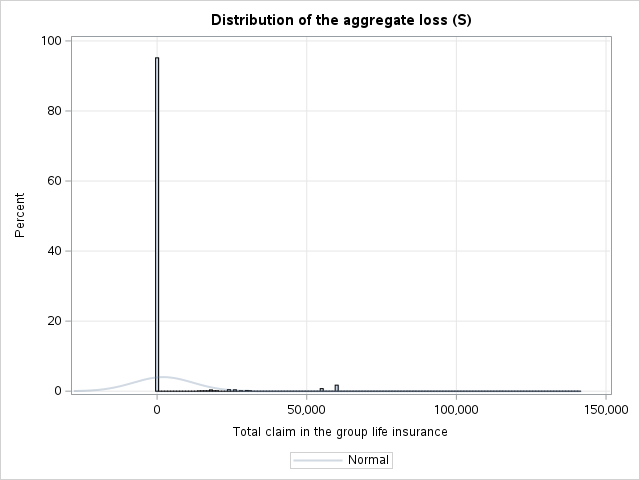

In [4]:
title "Distribution of the aggregate loss (S)";
proc sgplot data=work.aggclaim;
	histogram S;
	density S / type=normal transparency=0.7;
	xaxis grid;
	yaxis grid;
run;
title;

In [5]:
proc freq data=work.aggclaim;
run;

In [6]:
title "Are the simulated mean, variance and skewness similar to the previous results?";
proc means data=work.aggclaim mean var skewness;
	var S;
run;
title;

In [7]:
title "Probability of losing money in this contract";
proc sql;
	select count(*)/&m. as "P[S>G]"n
	from work.aggclaim
	where S > &G.;
quit;
title;

P[S>G]
0.048297


...

j) Calculate the exact distribution of 𝑆 with the following approach:
- Define every state of the world i.e. all the possible combinations with an alive/dead status for every employee, how many states of the world are there❓
- Calculate the total claim and the probability of every state of the world.
- Calculate the probability function of 𝑆.
Which approximation would you choose❓ Why❓

In [8]:
* Number of risk units in the individual risk model;
%let ne=14;
%put &=ne.;
* Gross premium;
%let G = 2947.72;

106  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
106! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml7.htm
107  
108  * Number of risk units in the individual risk model;
109  %let ne=14;
110  %put &=ne.;
NE=14
111  * Gross premium;
112  %let G = 2947.72;
113  ods html5 (id=saspy_internal) close;ods listing;
114  




In [9]:
%MACRO allcombinations(n=);
/*
Purpose: To calculate all the states of the world for each employee 
n: number of employees
*/
	* i is the number of deaths;
	%do i=1 %to &n.;
		* Computing the number of combinations;
		data _null_;
			call symputx('nc',comb(&n.,&i.));
		run;
		%put &=nc.;
		* Generating the combinations;
		proc plan seed=2025;
			factors iter=&nc. ordered id_employee = &i. of &n. comb / noprint;
			output out=comb_&i.;
		run;
		* Saving the results;
		data id_comb_&i.;			
			number_deaths=&i.;
			is_dead=1;
			set comb_&i.;
		run;
	%end;
	* Appending the results;
	data death;
		set id_comb_:;
	run;
	* Delete unuseful data sets;
	proc datasets lib=work nolist;
		delete id_comb_: comb_:;
	run;
	* i is the number of survivals;
	%do i=1 %to &n.;
		* Computing the number of combinations;
		data _null_;
			call symputx('nc',comb(&n.,&i.));
		run;
		%put &=nc.;
		* Generating the combinations;
		proc plan seed=2025;
			factors iter=&nc. ordered id_employee = &i. of &n. comb / noprint;
			output out=comb_&i.;
		run;
		* Saving the results;
		data id_comb_&i.;			
			number_deaths=&n.-&i.;
			is_dead=0;
			set comb_&i.;
			iter=&nc.-iter+1;
		run;
	%end;
	* Appending the results;
	data alive;
		set id_comb_:;
	run;
	* Delete unuseful data sets;
	proc datasets lib=work nolist;
		delete id_comb_: comb_:;
	run;
	* Appending the deaths and alives employees for each state of the world;
	data comb;
		set death alive;
	run;
	* Ordering the data set to understand better the states of the world;
	proc sort data=comb;
		by number_deaths iter;
	run;
	* Delete unuseful data sets;
	proc datasets lib=work nolist;
		delete death alive;
	run;
%MEND;

115  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
115! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml8.htm
116  
117  %MACRO allcombinations(n=);
118  /*
119  Purpose: To calculate all the states of the world for each employee
120  n: number of employees
121  */
122  	* i is the number of deaths;
123  	%do i=1 %to &n.;
124  		* Computing the number of combinations;
125  		data _null_;
126  			call symputx('nc',comb(&n.,&i.));
127  		run;
128  		%put &=nc.;
129  		* Generating the combinations;
130  		proc plan seed=2025;
131  			factors iter=&nc. ordered id_employee = &i. of &n. comb / noprint;
132  			output out=comb_&i.;
133  		run;
134  		* Saving the results;
135  		data id_comb_&i.;			
136  			number_deaths=&i.;
137  			is_dead=1;
138  			set comb_&i.;
139  		run;
140  	%end;
141  	* Appending the results;
142  	data death;
143  		set id_comb_:;
144  	run;
145  	* Delete unuseful d

In [10]:
* Execute the macro;
%allcombinations(n=&ne.);

192  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
192! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml9.htm
193  
194  * Execute the macro;
195  %allcombinations(n=&ne.);

NOTE: DATA statement used (Total process time):
      real time           0.00 seconds
      cpu time            0.00 seconds
      

NC=14
NOTE: At the start of processing, random number seed=2025.

NOTE: The data set WORK.COMB_1 has 14 observations and 2 variables.
NOTE: At the  end  of processing, random number seed=2025.
NOTE: PROCEDURE PLAN used (Total process time):
      real time           0.00 seconds
      cpu time            0.00 seconds
      


NOTE: There were 14 observations read from the data set WORK.COMB_1.
NOTE: The data set WORK.ID_COMB_1 has 14 observations and 4 variables.
NOTE: DATA statement used (Total process time):
      real time           0.00 seconds
      cpu time            0.00 seconds


In [11]:
* Create the matrix of the parameters for each employee;
proc iml;
	
	* Number of risk units in the individual risk model;
	n=&ne.;
	* Matrix for the parameters;
	par=j(n,4,.);
	* ID employee;
	par[,1]=t(do(1,n,1));
	* Benefits;
	par[,2]={15000,16000,20000,28000,31000,18000,26000,24000,60000,14000,17000,19000,30000,55000};
	*par[,2]={15000,16000,20000};
	* Mortality rates;
	par[,3]={0.000965,0.001069,0.001252,0.001434,0.001505,0.003751,0.004037,0.004698,0.017778,0.000884,0.001031,0.001201,0.002078,0.007682};
	*par[,3]={0.000965,0.001069,0.001252};
	* Survival rates;
	par[,4]=1-par[,3];
	print par;
	varNames={"id_employee","benefit","q","p"};
	* Sending the results to a dataset;
	create par from par[colname=varNames];
	append from par;
	close par;	
quit;

In [12]:
* Joining the states of the world with the parameters;
proc sql;
	create table full_comb as
	select
	b.*
	, case is_dead
	when 1 then benefit
	when 0 then 0 
	else 0 end as claim
	, case is_dead
	when 1 then q
	when 0 then p 
	else 0 end as prob
	from work.par a right join work.comb b on (a.id_employee = b.id_employee)
	order by number_deaths, iter
	; 
quit;

226  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
226! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml11.htm
227  
228  * Joining the states of the world with the parameters;
229  proc sql;
230  	create table full_comb as
231  	select
232  	b.*
233  	, case is_dead
234  	when 1 then benefit
235  	when 0 then 0
236  	else 0 end as claim
237  	, case is_dead
238  	when 1 then q
239  	when 0 then p
240  	else 0 end as prob
241  	from work.par a right join work.comb b on (a.id_employee = b.id_employee)
242  	order by number_deaths, iter
243  	;
NOTE: Table WORK.FULL_COMB created, with 229376 rows and 6 columns.

244  quit;
NOTE: PROCEDURE SQL used (Total process time):
      real time           0.07 seconds
      cpu time            0.17 seconds
      

245  ods html5 (id=saspy_internal) close;ods listing;
246  




In [13]:
* Computing the total claim and its probability for each state of the world;
proc sql;
	create table full_comb2 as
	select
	number_deaths
	, iter
	, sum(claim) as S
	, EXP(SUM(LOG(prob))) as prob
	from full_comb
	group by number_deaths, iter
	;
quit;


247  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
247! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml12.htm
248  
249  * Computing the total claim and its probability for each state of the world;
250  proc sql;
251  	create table full_comb2 as
252  	select
253  	number_deaths
254  	, iter
255  	, sum(claim) as S
256  	, EXP(SUM(LOG(prob))) as prob
257  	from full_comb
258  	group by number_deaths, iter
259  	;
NOTE: Table WORK.FULL_COMB2 created, with 16384 rows and 4 columns.

260  quit;
NOTE: PROCEDURE SQL used (Total process time):
      real time           0.03 seconds
      cpu time            0.03 seconds
      

261  
262  ods html5 (id=saspy_internal) close;ods listing;
263  




In [14]:
* Grouping by total claim and its probability;
proc sql;
	create table full_comb3 as
	select
	S format nlnum16.2 label="Total claim in the group life insurance"
	, sum(prob) as prob format 16.6 label="Probability"
	from full_comb2
	group by S
	order by S
	;
quit;

264  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
264! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml13.htm
265  
266  * Grouping by total claim and its probability;
267  proc sql;
268  	create table full_comb3 as
269  	select
270  	S format nlnum16.2 label="Total claim in the group life insurance"
271  	, sum(prob) as prob format 16.6 label="Probability"
272  	from full_comb2
273  	group by S
274  	order by S
275  	;
NOTE: Table WORK.FULL_COMB3 created, with 338 rows and 2 columns.

276  quit;
NOTE: PROCEDURE SQL used (Total process time):
      real time           0.01 seconds
      cpu time            0.01 seconds
      

277  ods html5 (id=saspy_internal) close;ods listing;
278  




In [15]:
title "Distribution of the aggregate loss (S)";
proc print data=full_comb3 noobs;
run;
title;

S,prob
0.00,0.951621
"14,000.00",0.000842
"15,000.00",0.000919
"16,000.00",0.001018
"17,000.00",0.000982
"18,000.00",0.003583
"19,000.00",0.001144
"20,000.00",0.001193
"24,000.00",0.004492
"26,000.00",0.003857


In [16]:
title "Validation of the Distribution of the aggregate loss (S)";
proc means data=full_comb2 sum min max;
	var prob;
run;
title;


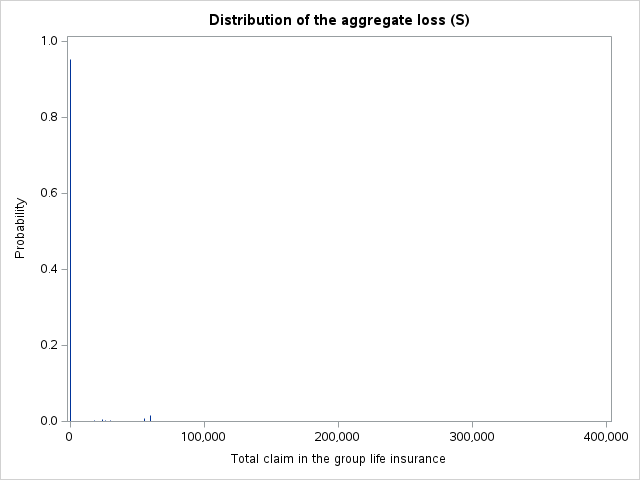

In [17]:
title "Distribution of the aggregate loss (S)";
proc sgplot data=full_comb3;
	needle x=S y=prob;
run;
title;

In [18]:
title "Probability of losing money in this contract";
proc sql;
	select sum(prob) as "P[S>G]"n
	from full_comb3
	where S > &G.;
quit;
title;

P[S>G]
0.048379
